In [1]:
# %load basic_imports.py
from scipy import *
from qutip import *
from sympy import *
from matplotlib import *
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import colors
from matplotlib import cm

In [2]:
from Lib.Parametrs import *
import Lib.Bloch_sphere as bloch

In [11]:
#analytical solution

ω_0 = Symbol("ω_0", real=True, positive=True)
δω = Symbol("δω", real=True, positive=True)
Ω_R = Symbol("Ω_R", real=True, positive=True)
Ω_R_g = Symbol("Ω_R^g", real=True, positive=True)

γ = Symbol("γ", real=True, positive=True)
γ_ϕ = Symbol("γ_ϕ", real=True, positive=True)
t = Symbol("t", real=True, positive=True)
ρ_11 = Function("ρ_11")(t)
ρ_12 = Function("ρ_12")(t)
ρ_21 = Function("ρ_21")(t)
ρ_22 = Function("ρ_22")(t)
c_1 = Function("c_1")(t)
c_2 = Function("c_2")(t)

ρ = Matrix([[ρ_11,ρ_12],[ρ_21, 1-ρ_11]]) 
σ_z = Matrix([[1,0],[0,-1]]) 
σ_m = Matrix([[0,0],[1,0]]) 
σ_p = Matrix([[0,1],[0,0]])
σ_x = σ_m+σ_p

Matrix([[ρ_11(t), ρ_12(t)], [ρ_21(t), 1 - ρ_11(t)]])


In [15]:
#lindbladian operator

L_ϕ = sqrt(γ_ϕ/2)*σ_z
L_r = sqrt(γ)*σ_m

def D(L_ϕ, L_r, γ_ϕ, γ, ρ):
    D_ϕ = L_ϕ*ρ*L_ϕ.adjoint() - ρ*L_ϕ.adjoint()*L_ϕ/2 - L_ϕ.adjoint()*L_ϕ*ρ/2
    D_r = L_r*ρ*L_r.adjoint() - ρ*L_r.adjoint()*L_r/2 - L_r.adjoint()*L_r*ρ/2
    return  D_ϕ + D_r


H = (δω/2*σ_z + Ω_R/2*σ_x)
print(D(L_ϕ, L_r, γ_ϕ, γ, ρ))

Matrix([[-γ*ρ_11(t), -γ*ρ_12(t)/2 - γ_ϕ*ρ_12(t)], [-γ*ρ_21(t)/2 - γ_ϕ*ρ_21(t), γ*ρ_11(t)]])


In [4]:
OmegaQ = 2*pi * 1
OmegaR = 1.
OmegaD = 1.

gamma_rel = 0.
gamma_deph = 0.1
Amp = 0.02*pi*20


#initial hamiltonian
def Hq(Omega):
    Hq = OmegaQ * sigmaz()/2
    return Hq
    
def He(OmegaR):
    He = OmegaR * sigmax()/2
    return He
    
def Hi(Amp, OmegaD, phi): 
    Hi = Amp * np.cos(OmegaD*t+phi) * sigmaz()/2
    return Hi
    
#hamiltonian after RWA

def H_RWA(OmegaQ, OmegaD):
    delta = OmegaQ - OmegaD
    H_RWA = delta * sigmaz()/2 + OmegaR * sigmax()/2
    return H_RWA

def H_inf():
    phi = 0
    A = 1
    H_inf = A/2*(sigmax()*np.cos(phi)-1j*sigmay()*np.sin(phi))
    return H_inf

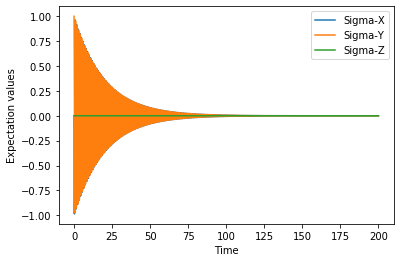

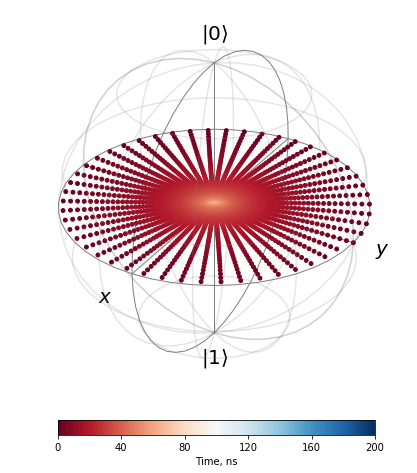

In [5]:
#evolution
from matplotlib import colors
#duration
times = np.linspace(0, 200, 10000)

#initial state: the state vector or density matrix (`rho0`) 
#r = [0, 0, 1]
r = [0, 1, 0]
psi0 = bloch.convert.r_to_rho(r)


result = mesolve(Hq(1), psi0, times, [np.sqrt(gamma_rel)*sigmam()+np.sqrt(gamma_deph)*sigmaz()/2],\
                 [sigmax() ,sigmay(), sigmaz()])


#ploting ?progections?
fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0])
ax.plot(result.times, result.expect[1])
ax.plot(result.times, result.expect[2])
ax.set_xlabel('Time')
ax.set_ylabel('Expectation values')
ax.legend(("Sigma-X", "Sigma-Y", "Sigma-Z"))
plt.show()


#ploting bloch sphere
expects = np.array(result.expect)
nrm = colors.Normalize(0, times[-1])
colors = cm.RdBu(nrm(times))


fig = plt.figure(figsize=(7,7))
axes = fig.add_axes([0.1, 0.2, 0.8, 0.8], projection="3d")
sph = Bloch(fig=fig, axes=axes)
sph.sphere_alpha = 0 #transparency
sph.xlpos = [1.3, -1.3]
sph.point_size=[60]
# axes.view_init(elev=10)

sph.point_color = list(colors)
sph.point_marker=['.']
sph.add_points(expects[:, :], meth='m')
sph.render(fig, axes)
m = cm.ScalarMappable(cmap = cm.RdBu, norm=nrm)
m.set_array(times)
m.set_clim(0, times[-1])
position=fig.add_axes([0.2,0.15,0.63,0.03])
cb = fig.colorbar(m, orientation='horizontal', cax=position)
cb.set_label("Time, ns")
cb.set_ticks(np.linspace(0,round(times[-1]),6))



In [6]:
#propogator defenition 

delta = 1.
epsilon = 1.

def U(delta, epsilon):
    theta = delta/2/epsilon
    U = np.exp(1j*theta*sigmaz())

    
def H_Rabi(delta, epsilon):
    H_RWA = delta * sigmax()/2 + epsilon * sigmaz()/2
    return H_Rabi

print(H_Rabi(delta, epsilon))
#H = U(delta, epsilon).dag()*H_Rabi(delta, epsilon)*U(delta, epsilon)

<function H_Rabi at 0x000001A588FECD38>


In [7]:
#drive

Amp = 1.
OmegaD = 1.
phi = 0.

#duraton
times = np.linspace(0, 200, 10000)


def Hi(Amp, OmegaD, phi, t): 
    Hi = Amp * np.cos(OmegaD*t+phi) * sigmaz()/2
    return Hi


